# CA5 - Pepper spiciness prediction

In [1]:
import pandas as pd
import seaborn as sns 
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVC

## 1. Reading and cleaning data
Firstly we read in the data and see what missing data there is. This shows that there are 648 of 1000 entries of "Average Temperature During Storage (Celsius)" are missing. This is more than 50% and we feel like imputing this data by using the mean or something else would not make any sense and just introduce noise. Therefore we choose to remove it and then remove the other entries which are missing data.

Then we hot-encode the categorical variables to numerical ones using the pandas get.dummies function.

After, we create a pairplot to visualise the data, from which we see some variables which have more of a linear relationship than others. 
We confirm this with the correlation matrix. We left out the hot-encoded variables to make it more readable, but this means it does not show the correlation between these variables. 

In [2]:
traindata = pd.read_csv("data/train.csv")
testdata = pd.read_csv("data/test.csv")

missing_values = traindata.isnull().sum()
print(missing_values)

Length (cm)                                            1
Width (cm)                                             1
Weight (g)                                             1
Pericarp Thickness (mm)                                2
Seed Count                                             1
Capsaicin Content                                      1
Vitamin C Content (mg)                                 0
Sugar Content                                          1
Moisture Content                                       0
Firmness                                               1
color                                                  1
Harvest Time                                           0
Average Daily Temperature During Growth (celcius)      0
Average Temperature During Storage (celcius)         648
Scoville Heat Units (SHU)                              0
dtype: int64


In [3]:
# Removing the Average Temperature During storage since more than half of the entries are missing this value.
traindata = traindata.drop(columns=["Average Temperature During Storage (celcius)"])

# Then dropping the remaining entries which contain a NaN
traindata = traindata.dropna(axis=0)
missing_values = traindata.isnull().sum()

In [4]:
# Go from categorical to numerical using the pandas function 'get_dummies'
traindata = pd.get_dummies(traindata, columns=['color', "Harvest Time"], dtype=int)
traindata

,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,Average Daily Temperature During Growth (celcius),Scoville Heat Units (SHU),color_green,color_red,color_yellow,Harvest Time_Evening,Harvest Time_Midday,Harvest Time_Morning
0,17.37,5.42,94.30,4.90,193.93,3.21,173.59,6.15,88.59,3.40,8.68,0.00,0,1,0,0,1,0
1,27.78,4.75,262.71,6.56,186.29,8.19,100.41,2.36,111.20,5.45,22.44,0.00,1,0,0,0,1,0
2,6.17,3.51,66.72,7.96,298.81,4.69,125.91,6.75,72.98,2.77,24.99,455995.06,0,1,0,0,1,0
3,6.12,6.07,51.24,4.57,39.36,2.76,143.54,5.93,63.93,1.62,13.05,0.00,0,0,1,0,1,0
4,28.58,4.84,166.51,3.07,194.07,7.01,193.76,2.85,88.19,3.99,27.08,0.00,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8.67,6.51,19.00,2.87,1.53,0.63,9.02,0.63,95.54,4.86,16.57,88266.90,0,0,1,1,0,0
996,17.17,9.25,150.86,1.41,386.87,2.27,268.93,2.21,131.71,2.59,22.39,0.00,0,0,1,0,0,1
997,14.16,6.87,124.72,1.97,202.83,3.31,203.84,2.90,114.42,3.17,15.84,0.00,0,0,1,1,0,0
998,3.71,7.12,29.53,1.05,115.61,9.80,45.95,2.39,97.70,4.01,16.05,188390.86,1,0,0,1,0,0


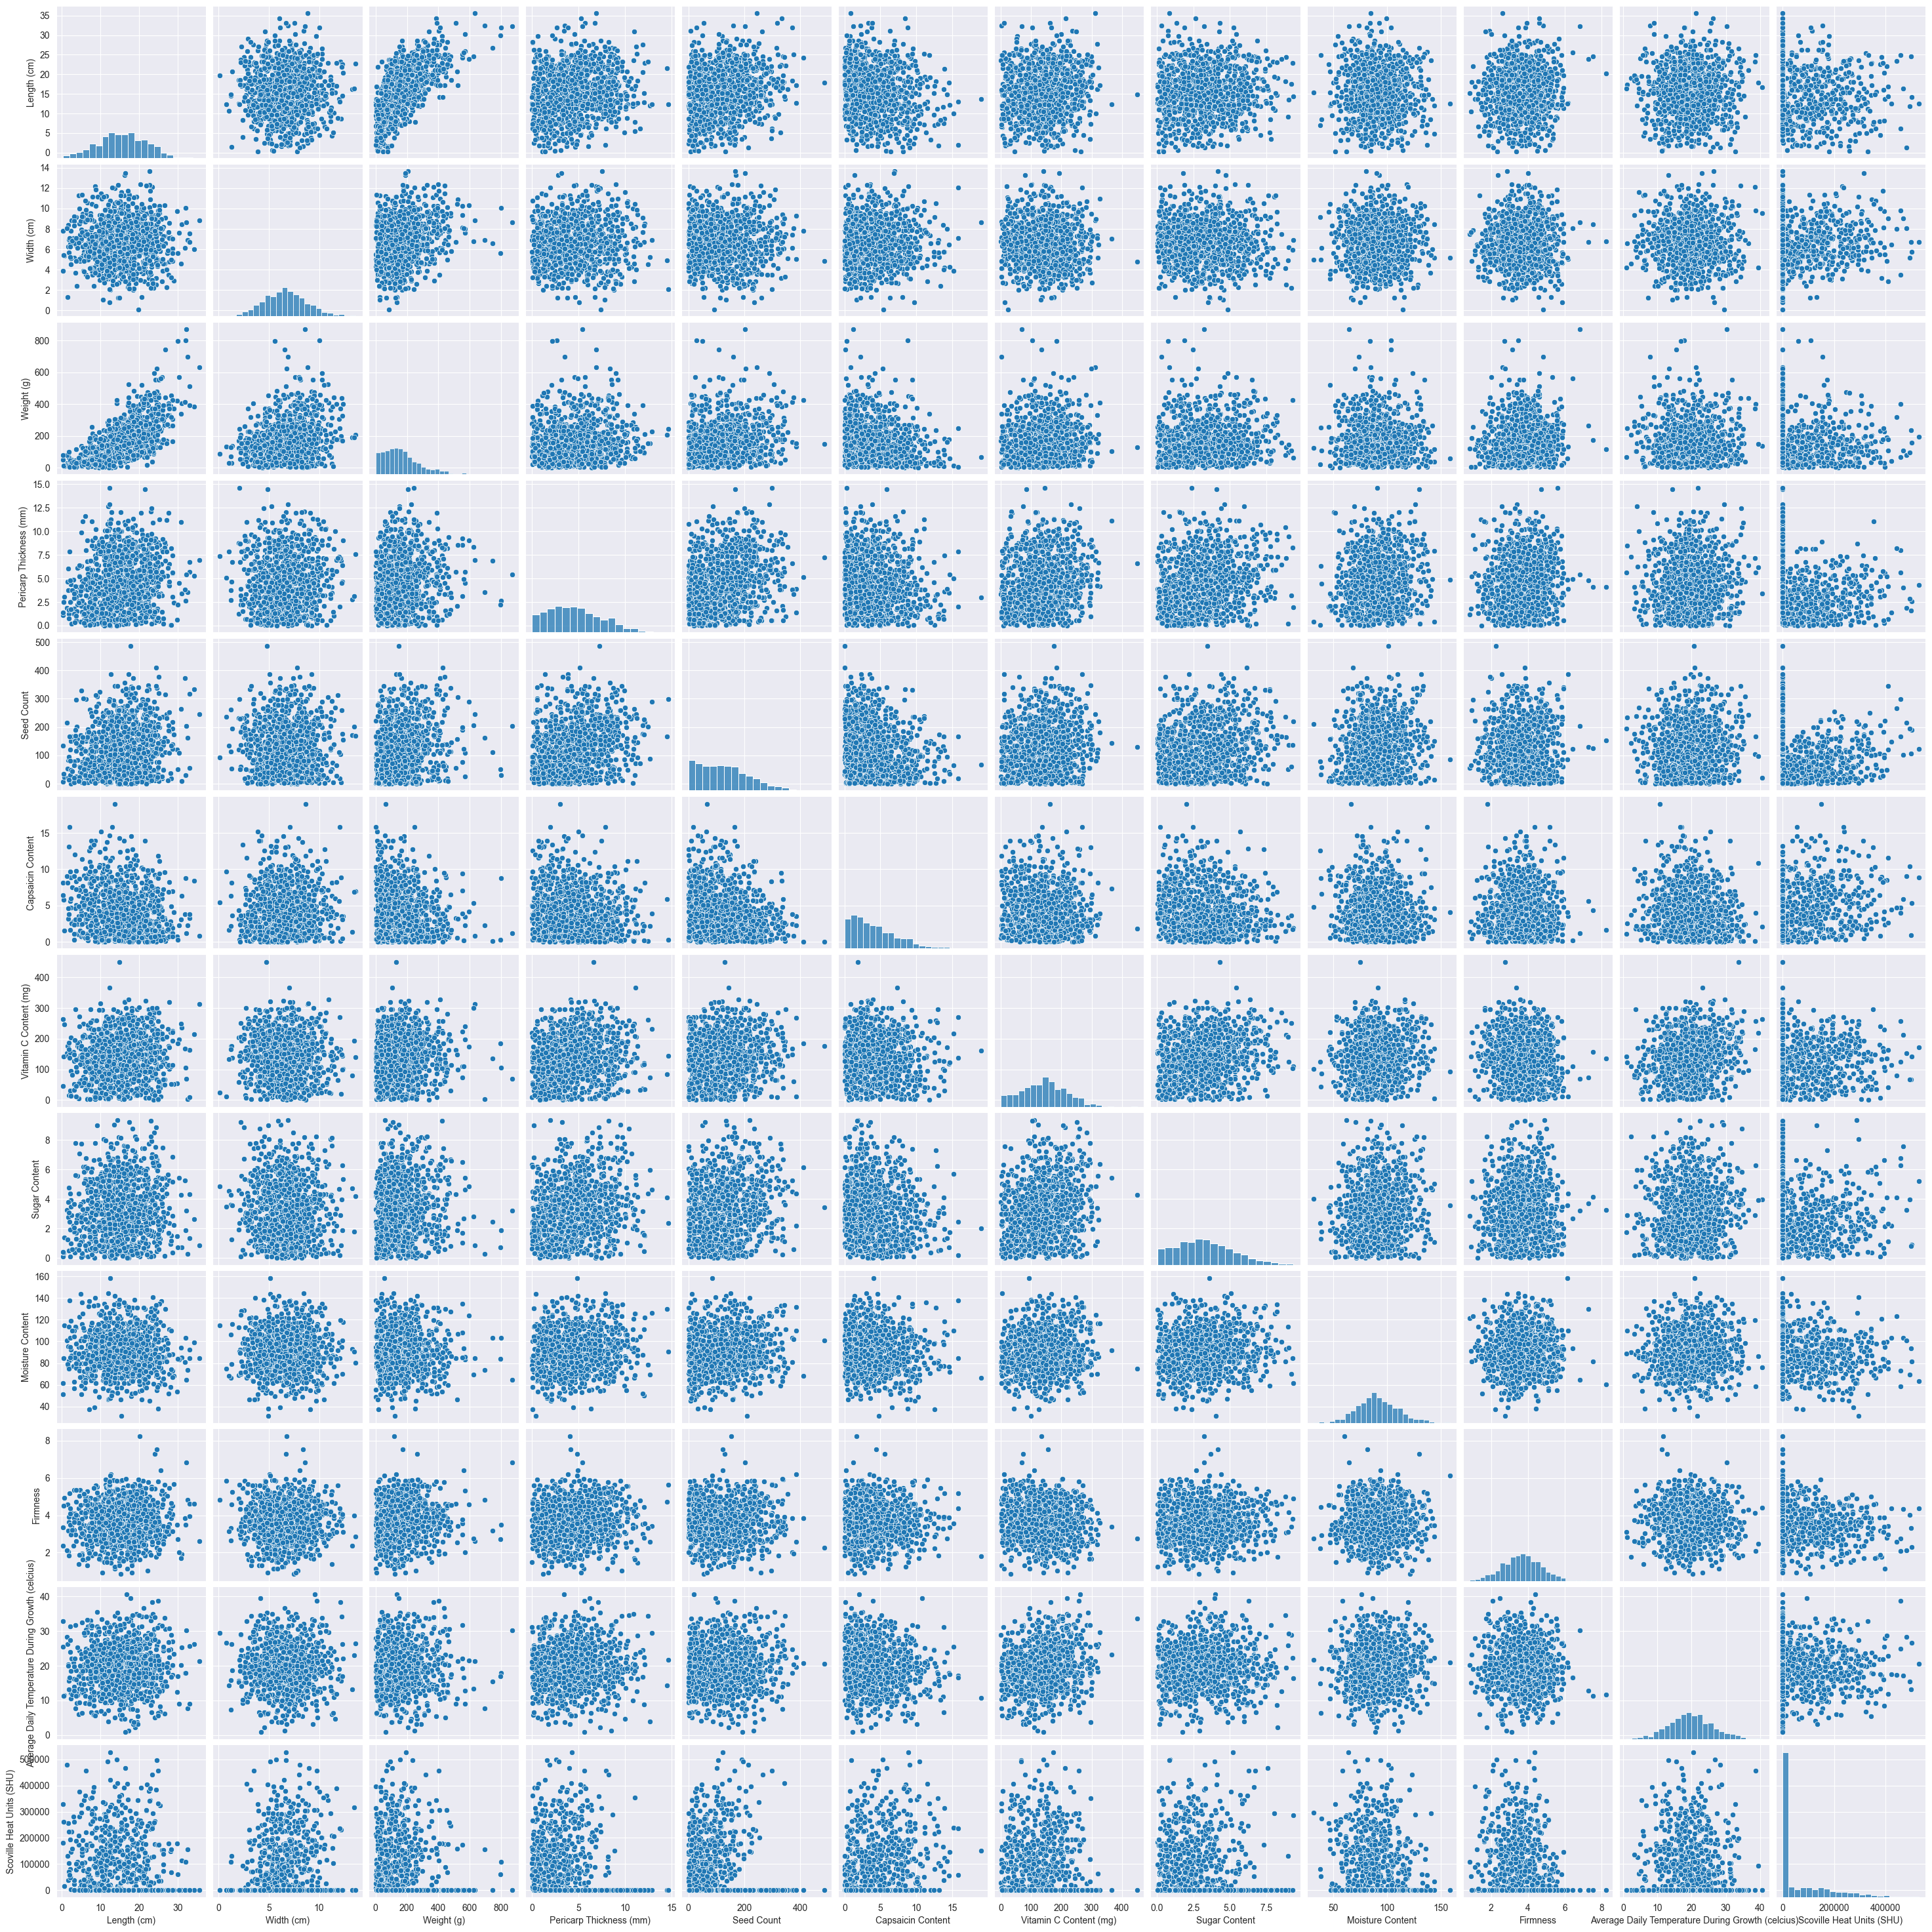

In [5]:
sns.pairplot(traindata.drop(columns=["color_green", "color_red", "color_yellow", "Harvest Time_Evening", "Harvest Time_Midday", "Harvest Time_Morning"]))

<Axes: >

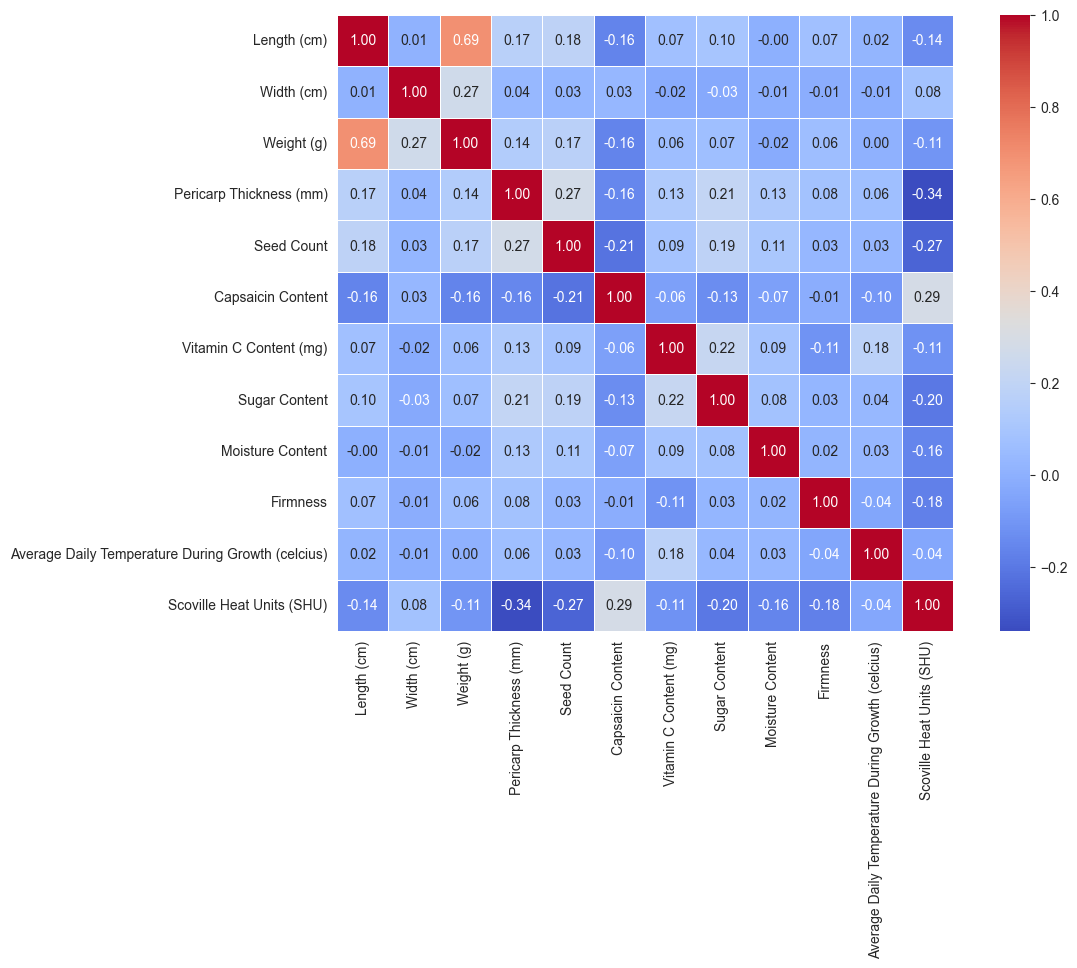

In [6]:
corr_matrix = traindata.drop(columns=["color_green", "color_red", "color_yellow", "Harvest Time_Evening", "Harvest Time_Midday", "Harvest Time_Morning"]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

## 2. Multi class classification analysis with ensemble classifier
The criteria of the assignment were to use atleast two of the three pipelines given.
Here, we use the the binning multi class classification with ensemble classifier. 

We chose to use the class "MajorityVoteClassifier" given in the Chapter_7_part_1.ipynb file with one small modifiation to get it to work. This is described in the class itself with a comment.
For the models we got the best result by using KNN, SVC and a logisticregression model. 

In [7]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        # The init definition in the class will be run when a MajorityVoteClassifier object is created.

        self.classifiers = classifiers
        # Dictionary comprehension for named classifier lookup (used for returning parameters)
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        # Check that inputs are valid
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y) # This works equally well for strings, integers, floats, ...
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            # Cloning is important to enable use with model_selection
            # (no entanglement between different instantiatons of the classifier).
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.

        """
        if self.vote == 'probability': # Weighting happens in .predict_proba()
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            # Compact notation of: "for every observation, do weighted majority voting"
            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                      # bincount counts the occurrences of integers from 0 to max(x)
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        # maj_vote is transformed back to the original labels
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights) # axis=0 is the classifier axis
        return avg_proba


    # Our change made it easier to use the majority vote classifier with unnamed classifiers
    # This caused a lot of problems early on when trying to get this to work. 
    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = {}
            for idx, clf in enumerate(self.classifiers):
                for key, value in clf.get_params(deep=True).items():
                    out[f'classifier{idx}__{key}'] = value
                out[f'classifier{idx}'] = clf
            return out

In [8]:
# Creating the X and Y datasets
X = traindata.drop(columns=["Scoville Heat Units (SHU)"], axis=0)
y = traindata["Scoville Heat Units (SHU)"]

In [9]:
# Binning y
num_bins = 5
binned = pd.qcut(y, q=num_bins, duplicates='drop')
y_binned = binned.cat.codes


# Defining classifiers
pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

pipe_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True))
])

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

# Create the majority vote classifier object
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe_knn, pipe_svc, pipe_lr],
    vote="classlabel"
)


# Define the param grid using those names
# Here we apply the change we made in the class, and use the given names "classifierX"
param_grid = {
    'classifier0__knn__n_neighbors': [3, 5, 7],
    'classifier1__svc__C': [0.1, 1, 10],
    'classifier1__svc__kernel': ['linear', 'rbf'],
    'classifier2__logreg__C': [0.01, 0.1, 1]
}


# Run GridSearch using accuracy since the MAE does not work here
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=param_grid,
                    cv=5,
                    scoring='accuracy',
                    n_jobs=-1)

grid.fit(X, y_binned)

print("Best parameters:")
print(grid.best_params_)
print(f"Best accuracy: {grid.best_score_:.4f}")

Best parameters:
{'classifier0__knn__n_neighbors': 7, 'classifier1__svc__C': 10, 'classifier1__svc__kernel': 'linear', 'classifier2__logreg__C': 0.1}
Best accuracy: 0.6778


In [10]:
# Fetch the best parameters
best_params = grid.best_params_

# creating the majorityvoteclassifier 
best_mv_clf = MajorityVoteClassifier(
    classifiers=[pipe_knn, pipe_svc, pipe_lr],  # original pipelines
    vote="classlabel"
)

# Apply the best parameters for each model
best_mv_clf.set_params(**best_params)

# Loop over different number of bins and print accuracy
for num_bins in [3, 5, 7, 10, 15]:
    binned = pd.qcut(y, q=num_bins, duplicates="drop")
    y_binned = binned.cat.codes

    scores = cross_val_score(best_mv_clf, X, y_binned, cv=10, scoring="accuracy")
    print(f"Bins: {num_bins} = Mean CV accuracy: {scores.mean():.4f}")

Bins: 3 = Mean CV accuracy: 0.7636
Bins: 5 = Mean CV accuracy: 0.6677
Bins: 7 = Mean CV accuracy: 0.6414
Bins: 10 = Mean CV accuracy: 0.6182
Bins: 15 = Mean CV accuracy: 0.6000


When increasing the number of bins, the final accuracy of the model goes down. When thinking about it, this makes sense.
If there are say 3 bins, this means the model has a much greater chance of putting the entry it is predicting in the right bin, even if the MAE still is quite large and the predicted result is far from the correct result. It gives a much greater chance of just placing the entry in the correct bin by luck.
When the number of bins increase, the accuracy goes down, as the model finds it harder to place every entry in the now smaller bins. This makes the accuracy go down.
After a certain amount of bins, here around 10, the accuracy seems to stabilize. This could indicate that it places the same, easy to predict, entries correctly in their bins even when the number of bins keep increasing, but the entries which are hard to predict keep being placed in the wrong bin. This makes it kind of stabilize after a given number of bins. 

## 3. Regression analysis

Another pipeline given in the criteria of the task was to do a regression analysis. This is here done with a ridge linear regression model, and to see how the results are affected by this, a residual plot was created and the R2-score was calculated to further look into the model.

The residual plot shows how far off the models predictions are from the actual values. Ideally, the residuals should be spread randomly above and below the zero line.
In this plot, there is still a lot of variation around the zero line, especially for peppers with higher predicted values. This means the model is not able to predict the spiciness accurately for all peppers.

weirdly, the validation R2 score is slightly higher than the training R2 score. This suggests that the model generalizes well and may have met slightly less variation or noise in the validation set, leading to better performance on unseen data.

In [11]:
# Pipeline
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

param_grid = {
    "ridge__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_rf.fit(X, y)

print("Best parameters:", grid_rf.best_params_)
print("Best MAE:", -grid_rf.best_score_)

Best parameters: {'ridge__alpha': 10.0}
Best MAE: 67729.47690440154


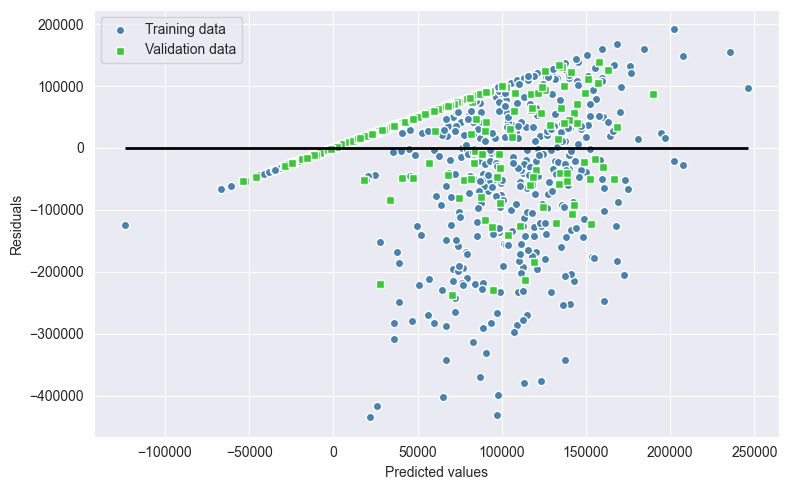

R2 (train): 0.2321
R2 (val)  : 0.2416


In [12]:
# Create a test-train split to create the plot and R2 scores
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


y_train_pred = grid_rf.predict(X_train)
y_val_pred = grid_rf.predict(X_val)

# Plot residuals (code fetched from chapter 10 part 1 notebook)
plt.figure(figsize=(8, 5))
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white', label='Training data')
plt.scatter(y_val_pred, y_val_pred - y_val,
            c='limegreen', marker='s', edgecolor='white', label='Validation data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=min(y_train_pred.min(), y_val_pred.min()),
           xmax=max(y_train_pred.max(), y_val_pred.max()),
           color='black', lw=2)
plt.tight_layout()
plt.show()

# R2 scores
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"R2 (train): {r2_train:.4f}")
print(f"R2 (val)  : {r2_val:.4f}")

## 4. Two-step analysis
The last of the three given pipelines was to create a two-step pipeline where we first classify between bell peppers (zero scoville score) and spicy peppers (nonzero scoville score). Then use a regression model to only predict the nonzero scoville scores and finally combine the results into one vector for uploading.

Since the scoville score is spread across such a large range, we chose to standardize these values by applying a logarithm transform to them. This brings them closer together and makes predictions much more accurate.
Then in the final upload, they are converted back to regular numbers. 

In [13]:
# Create a binary target
y_binary = (y > 0)  # 0 = non-spicy, 1 = spicy

# Create the BINARY classifier pipeline
# No need for grid search to optimize since it classifies everything correctly as it is
pipe_binary_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Fit the 
pipe_binary_clf.fit(X, y_binary)

# Evaluate accuracy on training set
y_binary_pred = pipe_binary_clf.predict(X)
binary_accuracy = accuracy_score(y_binary, y_binary_pred)
print(f"Binary classification accuracy (non-spicy vs spicy): {binary_accuracy}")

# Prepare spicy subset for regression
X_spicy = X[y > 0]
y_spicy = y[y > 0]
y_spicy_log = np.log1p(y_spicy)


# RandomForest regression pipeline
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define hyperparameter grid for RandomForest
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20]
}

# GridSearchCV for tuning
grid_rf = GridSearchCV(pipe_rf, param_grid, cv=5,
                       scoring="neg_mean_absolute_error", n_jobs=-1)

grid_rf.fit(X_spicy, y_spicy_log)

print("Best parameters:", grid_rf.best_params_)
print(f"Best MAE: {-grid_rf.best_score_:.2f}")

Binary classification accuracy (non-spicy vs spicy): 1.0
Best parameters: {'rf__max_depth': 10, 'rf__n_estimators': 100}
Best MAE: 0.80


## 5. Creating submission for Kaggle

In [ ]:
# One-hot encode and drop unwanted column
testdata = pd.get_dummies(testdata, columns=["color", "Harvest Time"], dtype=int)
testdata = testdata.drop(columns=["Average Temperature During Storage (celcius)"])

# Predict whether each test pepper is spicy or not
y_test_class = pipe_binary_clf.predict(testdata)

# Get indices of test peppers classified as spicy
spicy_indices = np.where(y_test_class == 1)[0]

# Predict log(scoville heat units) for spicy peppers
y_test_pred_log = grid_rf.predict(testdata.iloc[spicy_indices])

# Convert log predictions back to SHU scale
y_test_pred_shu = np.expm1(y_test_pred_log)

# Combine with SHU = 0 for bell peppers
y_final_pred = np.zeros(len(testdata))
y_final_pred[spicy_indices] = y_test_pred_shu

submission = pd.DataFrame(y_final_pred, columns=["Scoville Heat Units (SHU)"])
submission.index = testdata.index
submission.index.name = "index"
submission.to_csv("submission_two_step_logcorrected.csv", index=True)